In [1]:
import os
import tarfile

import numpy as np
import pandas as pd
from scipy.stats import randint
from six.moves import urllib
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


fetch_housing_data()
housing = load_housing_data()


In [3]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
# Train and Test split of the data
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Creating income category so that stratified smapling can be done
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

In [5]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

  income_cat  
0          5  
1          5  
2          5  
3          4  
4          3

<AxesSubplot: >

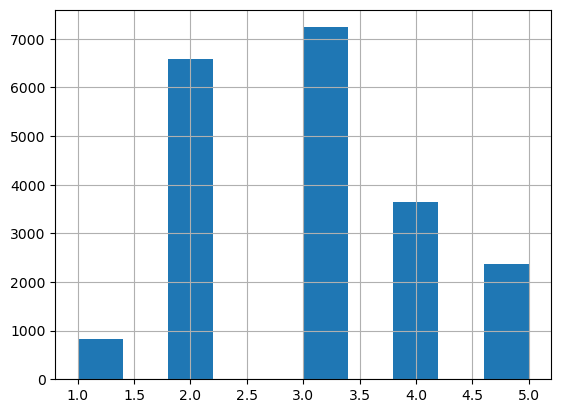

In [6]:
housing["income_cat"].hist()

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [8]:
train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14196    -117.03     32.71                33.0       3126.0           627.0   
8267     -118.16     33.77                49.0       3382.0           787.0   
17445    -120.48     34.66                 4.0       1897.0           331.0   
14265    -117.11     32.69                36.0       1421.0           367.0   
2271     -119.80     36.78                43.0       2382.0           431.0   

       population  households  median_income  median_house_value  \
14196      2300.0       623.0         3.2596            103000.0   
8267       1314.0       756.0         3.8125            382100.0   
17445       915.0       336.0         4.1563            172600.0   
14265      1418.0       355.0         1.9425             93400.0   
2271        874.0       380.0         3.5542             96500.0   

      ocean_proximity income_cat  
14196      NEAR OCEAN          3  
8267       NEAR OCEAN          3  
17445      NEAR OCEAN          3  
14265      NEAR OCEAN          2  
2271           INLAND          3

In [9]:
compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(strat_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()
compare_props["Rand. %error"] = (
    100 * compare_props["Random"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)


In [10]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039971  0.040213      0.973236       0.364964
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114341  0.109496     -4.318374      -0.084674

The sampling bias is very low in the case of stratified sampling as compared to the random sampling. The test set generated by using the stratified sampling technique has more or less identical income category proportion which is found in the overall dataset.

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

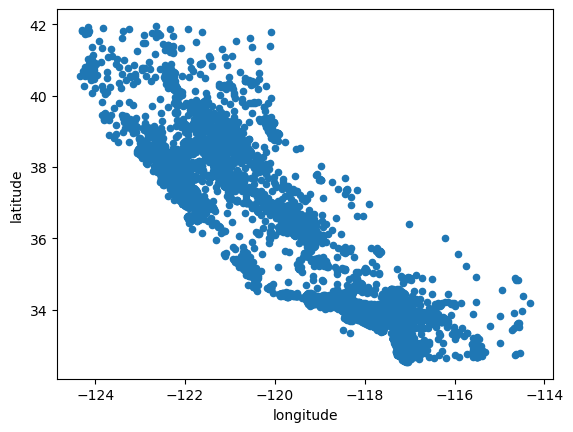

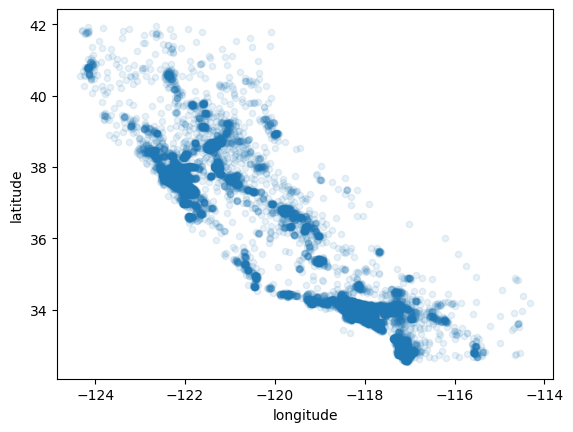

In [11]:

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

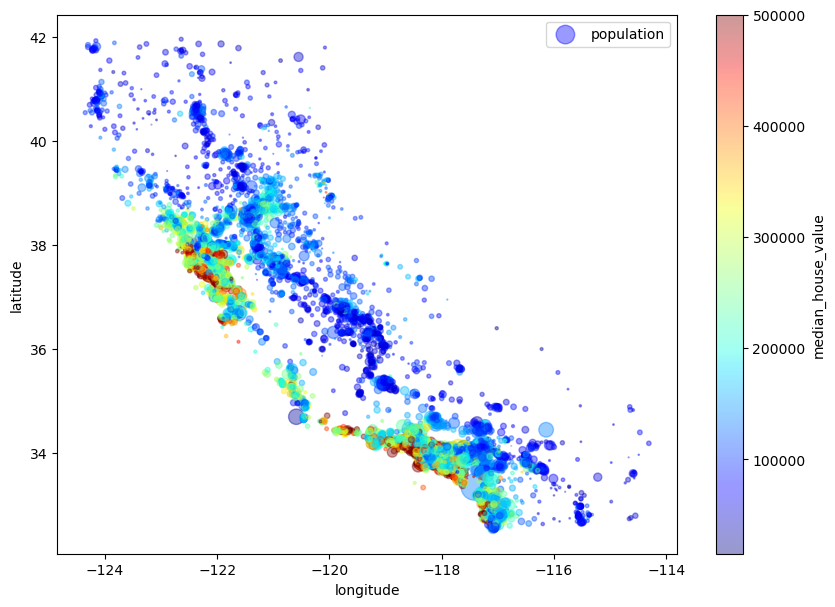

In [12]:
housing.plot(
    kind='scatter',
    x='longitude', y='latitude',
    alpha=0.4,
    s=housing["population"]/100,
    label='population',
    figsize=(10,7),
    c='median_house_value', cmap=plt.get_cmap('jet'),
    colorbar=True
)

The median house value appears to be higher for the coastal region and where the population density is higher.

In [13]:

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


/tmp/ipykernel_779/113942049.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [14]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = (
    housing["total_bedrooms"] / housing["total_rooms"]
)
housing["population_per_household"] = (
    housing["population"] / housing["households"]
)
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/tmp/ipykernel_779/968406444.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [15]:

housing = strat_train_set.drop(
    "median_house_value", axis=1
)  # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

imputer = SimpleImputer(strategy="median")

'''
Dropping the ocean_proximity which is a categorical 
attribute to use simple imputer Simple Imputer only 
works with numerical features
'''

housing_num = housing.drop("ocean_proximity", axis=1)

# Imputing for all the numerical features
imputer.fit(housing_num)
X = imputer.transform(housing_num)

# putting the data back into the pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

housing_tr["rooms_per_household"] = (
    housing_tr["total_rooms"] / housing_tr["households"]
)
housing_tr["bedrooms_per_room"] = (
    housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
)
housing_tr["population_per_household"] = (
    housing_tr["population"] / housing_tr["households"]
)

housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  rooms_per_household  \
12655      2237.0       706.0         2.1736             5.485836   
15502      2015.0       768.0         6.3373             6.927083   
2908        667.0       300.0         2.8750             5.393333   
14053       898.0       483.0         2.2264             3.886128   
20496      1837.0       580.0         4.4964             6.096552   

       bedrooms_per_room  population_per_household  
12655           0.205784                  3.168555  
15502           0.160714                  2.623698  
2908            0.191595                  2.223333  
14053           0.276505                  1.859213  
20496           0.182692                  3.167241

In [16]:
# using one hot encoding
housing_cat = housing[["ocean_proximity"]]
housing_prepared = housing_tr.join(
    pd.get_dummies(housing_cat, drop_first=True)
)


In [17]:
housing_prepared

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   
...          ...       ...                 ...          ...             ...   
15174    -117.07     33.03                14.0       6665.0          1231.0   
12661    -121.42     38.51                15.0       7901.0          1422.0   
19263    -122.72     38.44                48.0        707.0           166.0   
19140    -122.70     38.31                14.0       3155.0           580.0   
19773    -122.14     39.97                27.0       1079.0           222.0   

       population  households  median_income  rooms_per_household  \
12655      2237.0       706.0         2.1736             5.485836   
15502      2015.0       768.0         6.3373             6.927083   
2908        667.0       300.0         2.8750             5.393333   
14053       898.0       483.0         2.2264             3.886128   
20496      1837.0       580.0         4.4964             6.096552   
...           ...         ...            ...                  ...   
15174      2026.0      1001.0         5.0900             6.658342   
12661      4769.0      1418.0         2.8139             5.571932   
19263       458.0       172.0         3.1797             4.110465   
19140      1208.0       501.0         4.1964             6.297405   
19773       625.0       197.0         3.1319             5.477157   

       bedrooms_per_room  population_per_household  ocean_proximity_INLAND  \
12655           0.205784                  3.168555                       1   
15502           0.160714                  2.623698                       0   
2908            0.191595                  2.223333                       1   
14053           0.276505                  1.859213                       0   
20496           0.182692                  3.167241                       0   
...                  ...                       ...                     ...   
15174           0.184696                  2.023976                       0   
12661           0.179977                  3.363188                       1   
19263           0.234795                  2.662791                       0   
19140           0.183835                  2.411178                       0   
19773           0.205746                  3.172589                       1   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
12655                       0                         0   
15502                       0                         0   
2908                        0                         0   
14053                       0                         0   
20496                       0                         0   
...                       ...                       ...   
15174                       0                         0   
12661                       0                         0   
19263                       0                         0   
19140                       0                         0   
19773                       0                         0   

       ocean_proximity_NEAR OCEAN  
12655                           0  
15502                           1  
2908                            0  
14053                           1  
20496                           0  
...                           ...  
15174                           0  
12661                           0  
19263                           0  
19140                           0  
19773                           0  

[16512 rows x 15 columns]

### Exercise 1
Try a SVM regressor with various hyperparameters such as kernel='linear' with various values for the C hyperparameter or kernel = 'rbf'
with various values for the C and gamma.

In [18]:
param_grid = [
    {
        'kernel': ['linear'], 
        'C': [10, 50, 100, 1000, 30000]
    },

    {
        'kernel': ['rbf'],
        'C': [1.0, 30.0, 100.0, 500.0],
        'gamma': [0.01, 0.1, 0.5, 1, 3]
    }
]

In [19]:
svm_regressor = SVR()
grid_search = GridSearchCV(
    svm_regressor,
    param_grid,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=2
)
grid_search.fit(housing_prepared, housing_labels)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] END ................................C=10, kernel=linear; total time= 1.1min
[CV] END ................................C=10, kernel=linear; total time= 1.2min
[CV] END ................................C=50, kernel=linear; total time= 4.5min
[CV] END ................................C=50, kernel=linear; total time= 3.9min
[CV] END ...............................C=100, kernel=linear; total time= 8.2min
[CV] END ...............................C=100, kernel=linear; total time= 7.3min
[CV] END ..............................C=1000, kernel=linear; total time=30.2min
[CV] END ..............................C=1000, kernel=linear; total time=28.3min
[CV] END .............................C=30000, kernel=linear; total time=54.2min
[CV] END .............................C=30000, kernel=linear; total time=46.0min
[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   5.7s
[CV] END ......................C=1.0, gamma=0.01

GridSearchCV(cv=2, estimator=SVR(),
             param_grid=[{'C': [10, 50, 100, 1000, 30000],
                          'kernel': ['linear']},
                         {'C': [1.0, 30.0, 100.0, 500.0],
                          'gamma': [0.01, 0.1, 0.5, 1, 3], 'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [20]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70913.66340761207

In [21]:
grid_search.best_params_

{'C': 1000, 'kernel': 'linear'}